HW1 solution
======

## Behavioural cloning

TODO:
----
1. generate rollouts
This are sequences of the type expertSequence#1 = {s0 -> a0, s1 -> a1, s2 -> a3} done with the expert policy
<br>

- expert_data/something.pkl
- big number -> 18101
- observations.shape = (big number, 44)
- actions.shape = (big number, 17)
- returns.shape = (20, )
<br>
----
2. implement behavioural cloning
implement a neural net of the sort F(s) = a trained on all the expertSequence. Then create a policy using the neural net

In [1]:
import pickle as pk

In [2]:
expert_rollouts = pk.load(open("expert_data/RoboschoolHumanoid-v1.pkl","rb"))

In [3]:
expert_rollouts

{'observations': array([[ 2.3841858e-08,  1.6552746e-02,  9.9986297e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-1.2368917e-03,  1.5588514e-02,  9.9987847e-01, ...,
         -1.0157478e+00,  0.0000000e+00,  0.0000000e+00],
        [-6.5931440e-03, -5.2741389e-03,  9.9998611e-01, ...,
         -1.2476940e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-5.0809860e-01, -7.2747171e-01,  6.8613768e-01, ...,
          3.3137280e-01,  0.0000000e+00,  0.0000000e+00],
        [-5.4866636e-01, -7.2792214e-01,  6.8565977e-01, ...,
          7.0388418e-01,  0.0000000e+00,  0.0000000e+00],
        [-5.8901018e-01, -7.1578425e-01,  6.9832152e-01, ...,
          1.0054688e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32),
 'actions': array([[-0.15107152,  0.58659674,  0.59263927, ..., -0.66633345,
          0.03384994, -0.59625398],
        [-0.73595452,  0.18238143,  0.08968246, ..., -0.51464446,
         -0.03982098, -0.08909495],
        [ 0.1070570

In [4]:
expert_rollouts['observations'].shape

(18101, 44)

In [5]:
expert_rollouts['actions'].shape

(18101, 17)

In [6]:
expert_rollouts['returns'].shape

(20,)

In [7]:
inputs = expert_rollouts['observations']
outputs = expert_rollouts['actions']

In [21]:
assert len(inputs) == len(outputs)

In [22]:
split = int(len(inputs)*0.8)
print(split)

14480


In [24]:
X_train, y_train = inputs[:split], outputs[:split]
X_test, y_test = inputs[split:], outputs[split:]

model
========

In [8]:
import tensorflow as tf
import numpy as np

In [9]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [25]:
sess = tf_reset()
def create_model():
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 44]) # [None, 1] is because is 1D array
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 17])
    
    W0 = tf.get_variable(name='W0', shape=[44, 30], initializer = tf.contrib.layers.variance_scaling_initializer())
    W1 = tf.get_variable(name='W1', shape=[30, 23], initializer = tf.contrib.layers.variance_scaling_initializer())
    W2 = tf.get_variable(name='W2', shape=[23, 17], initializer = tf.contrib.layers.variance_scaling_initializer())
    
    
    b0 = tf.get_variable(name='b0', shape=[30], initializer = tf.constant_initializer(0))
    b1 = tf.get_variable(name='b1', shape=[23], initializer = tf.constant_initializer(0))
    b2 = tf.get_variable(name='b2', shape=[17], initializer = tf.constant_initializer(0))
    
    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, None]
    
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
            
    output_pred = layer
    return input_ph, output_ph, output_pred

In [26]:
input_ph, output_ph, output_pred = create_model()

In [27]:
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph)) # this is the mean square error
opt = tf.train.AdamOptimizer().minimize(mse) # this is an operation that pereform gradient descent

In [28]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver() # save weight as the training goes on

In [30]:
#training
batch_size = 32
training_mse = []
for training_step in range(30000):
    #random batch
    indices = np.random.randint(low = 0, high = len(X_train), size = batch_size)
    input_batch = X_train[indices]
    output_batch = y_train[indices]
    
    # run optimizer and get mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    training_mse.append(mse_run)
    if training_step % 1000 == 0:
        print('{0:04d} mse : {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')

0000 mse : 1.199
1000 mse : 0.034
2000 mse : 0.029
3000 mse : 0.025
4000 mse : 0.022
5000 mse : 0.018
6000 mse : 0.020
7000 mse : 0.016
8000 mse : 0.019
9000 mse : 0.021
10000 mse : 0.020
11000 mse : 0.018
12000 mse : 0.020
13000 mse : 0.017
14000 mse : 0.041
15000 mse : 0.015
16000 mse : 0.016
17000 mse : 0.016
18000 mse : 0.014
19000 mse : 0.015
20000 mse : 0.014
21000 mse : 0.015
22000 mse : 0.017
23000 mse : 0.018
24000 mse : 0.015
25000 mse : 0.018
26000 mse : 0.013
27000 mse : 0.016
28000 mse : 0.019
29000 mse : 0.013


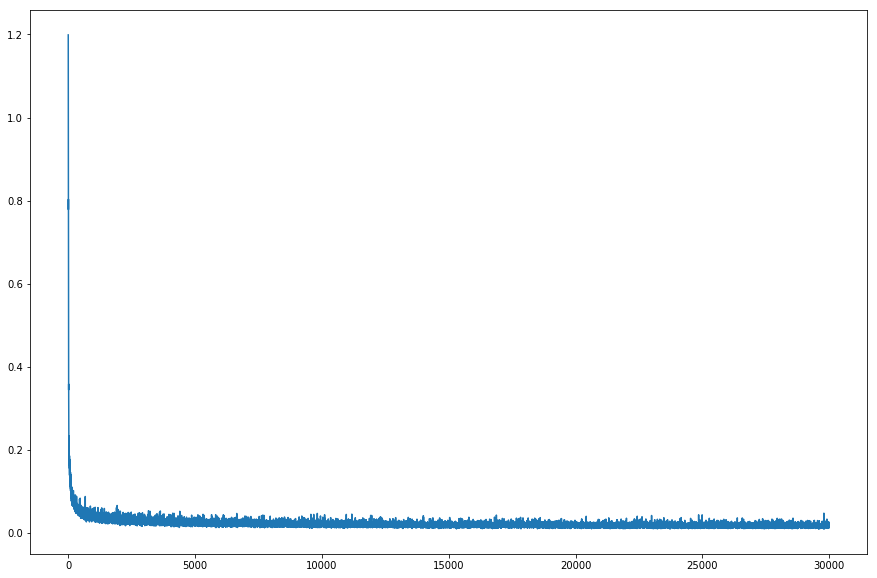

In [31]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(training_mse)
plt.show()

In [32]:
sess = tf_reset()

input_ph, output_ph, output_pred = create_model()
saver = tf.train.Saver() 
saver.restore(sess, "/tmp/model.ckpt")

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


In [ ]:
# validation score was 0.03

In [47]:
# prediction of only one action
output_pred_run = sess.run(output_pred, feed_dict={input_ph: X_test[0].reshape((1,44))})

In [48]:
output_pred_run

array([[-0.38433042,  0.226884  , -0.14036341,  0.42851037,  0.20954828,
         0.92404675,  0.08959147,  0.01009479,  0.2774955 ,  0.10493804,
         0.28418922, -0.14098293,  0.06038797, -0.14355713,  0.4186561 ,
        -0.10994124, -0.7232318 ]], dtype=float32)

In [49]:
y_test[0]

array([-0.3386859 ,  0.23773575, -0.3539861 ,  0.42342829,  0.17744512,
        0.72606769,  0.08928685,  0.10040049,  0.30771184, -0.00543482,
        0.17298833, -0.05066769,  0.10491692, -0.14766235,  0.26190663,
       -0.1574491 , -0.69997642])

In [50]:
mse = ((output_pred_run[0] - y_test[0])**2).mean(axis=None)

In [51]:
mse

0.009366397813987588